# **1. Demo Básica de Retrieval-Augmented Generation (BasicRAG) con Gemini:**

## **Preparación del entorno:**

In [1]:
# ================= DEMO RAG CON GEMINI ==================
!pip install chromadb sentence-transformers google-generativeai
!pip -q install nltk rouge-score matplotlib seaborn bert-score pandas transformers --upgrade

import os
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
import chromadb
from google.colab import files
from transformers import pipeline

In [2]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import bert_score as bs # Alias the impor
try:
    from bert_score import score
    bertscore_available = True
    print('BERTScore available!')
except ImportError:
    print('BERTScore not available - will use simulated scores')
    bertscore_available = False
nltk.download('punkt')
nltk.download('punkt_tab')
print('Setup complete.')

BERTScore available!
Setup complete.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
os.environ["GEMINI_API_KEY"] = ""
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [4]:
# ========= 2. SUBIR ARCHIVO =========
print("Sube un archivo de texto con información (ej: cuantica.txt)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
with open(file_name, "r", encoding="utf-8") as f:
    text = f.read()


Sube un archivo de texto con información (ej: cuantica.txt)


Saving cuantica.txt to cuantica (9).txt


In [5]:
# ========= 3. FUNCIÓN DE CHUNKING =========
def chunk_text(text, chunk_size=80, overlap=20):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
    return chunks

docs = chunk_text(text, chunk_size=80, overlap=20)

print("Ejemplo de 3 chunks creados:")
for c in docs[:3]:
    print("-", c, "\n")

Ejemplo de 3 chunks creados:
- Max Planck introdujo en 1900 la idea de que la energía no se emite de manera continua, sino en cuantos discretos. Este fue el inicio de la teoría cuántica. Albert Einstein en 1905 explicó el efecto fotoeléctrico utilizando el concepto de cuantos de luz, lo que posteriormente llamó fotones. Niels Bohr en 1913 propuso su modelo atómico, donde los electrones orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica 

- orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica que no es posible conocer con precisión la posición y el momento de una partícula al mismo tiempo. Erwin Schrödinger desarrolló la ecuación de onda en 1926, fundamental para describir el comportamiento cuántico de las partículas. Richard Feynman contribuyó a la electrodinámica cuántica y popularizó el uso de diagramas que

In [6]:
# ========= 4. CREAR EMBEDDINGS Y BASE VECTORIAL =========
embedder = SentenceTransformer("all-MiniLM-L6-v2")
client = chromadb.Client()
collection = client.get_or_create_collection("physics_chunks")

embeddings = embedder.encode(docs).tolist()
for i, d in enumerate(docs):
    collection.add(documents=[d], embeddings=[embeddings[i]], ids=[str(i)])



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# ========= 5. CONSULTA Y RETRIEVAL =========
# 👉 Aquí puedes cambiar la pregunta y experimentar ========================================
# Ejemplos para probar:
# query = "¿Qué explica la teoría de la relatividad?"
# query = "¿Cuál fue un hecho clave en la independencia de Colombia?"
query = "¿Qué científico propuso un modelo atómico en 1913?"
q_embed = embedder.encode([query]).tolist()
results = collection.query(query_embeddings=q_embed, n_results=3)
retrieved_context = " ".join(results['documents'][0])

print("\n🔹 Chunks relevantes recuperados:")
for doc in results['documents'][0]:
    print("-", doc)



🔹 Chunks relevantes recuperados:
- Max Planck introdujo en 1900 la idea de que la energía no se emite de manera continua, sino en cuantos discretos. Este fue el inicio de la teoría cuántica. Albert Einstein en 1905 explicó el efecto fotoeléctrico utilizando el concepto de cuantos de luz, lo que posteriormente llamó fotones. Niels Bohr en 1913 propuso su modelo atómico, donde los electrones orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica
- orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica que no es posible conocer con precisión la posición y el momento de una partícula al mismo tiempo. Erwin Schrödinger desarrolló la ecuación de onda en 1926, fundamental para describir el comportamiento cuántico de las partículas. Richard Feynman contribuyó a la electrodinámica cuántica y popularizó el uso de diagramas 

In [8]:

# ========= 6. GEMINI PARA RESPONDER CON CONTEXTO =========
model = genai.GenerativeModel("models/gemini-1.5-flash-latest")


prompt1= f"Basándote en el siguiente contexto, responde la pregunta y añade una breve explicación adicional desde tu conocimiento si es relevante:.\n\nContexto:\n{retrieved_context}\n\nPregunta: {query}"

response = model.generate_content(prompt1)

print("\n🔹 Respuesta generada por Gemini:")

contexto1 = retrieved_context
respuesta1= response.text
print(respuesta1)


🔹 Respuesta generada por Gemini:
Niels Bohr propuso un modelo atómico en 1913.  Este modelo postulaba que los electrones orbitan el núcleo atómico en niveles de energía discretos y cuantizados, a diferencia de los modelos clásicos que permitían órbitas con cualquier energía.  Este fue un paso crucial en el desarrollo de la teoría cuántica, ya que explicaba, por ejemplo, el espectro de emisión del hidrógeno.  Es importante notar que el modelo de Bohr, aunque histórico y didácticamente útil,  es una simplificación y fue posteriormente refinado y reemplazado por modelos más complejos y precisos basados en la mecánica cuántica.



In [9]:
model = genai.GenerativeModel("models/gemini-1.5-flash-latest")


prompt2= f" responde la pregunta y añade una breve explicación adicional desde tu conocimiento si es relevante:\n\nPregunta: {query}"

response2 = model.generate_content(prompt2)

print("\n🔹 Respuesta generada por Gemini:")

respuesta2= response2.text
print(respuesta2)


🔹 Respuesta generada por Gemini:
Niels Bohr propuso un modelo atómico en 1913.

**Explicación adicional:** El modelo atómico de Bohr mejoró significativamente el modelo anterior de Rutherford.  Mientras que el modelo de Rutherford describía el átomo con un núcleo denso positivo rodeado de electrones, no explicaba por qué los electrones no caían en el núcleo debido a la atracción electrostática.  Bohr introdujo la idea de que los electrones orbitan el núcleo en niveles de energía específicos o "capas", y que los electrones solo pueden saltar entre estas capas absorbiendo o emitiendo energía en forma de fotones.  Este modelo explicó con éxito el espectro de emisión del hidrógeno, pero tenía limitaciones y no podía explicar átomos con más de un electrón con la misma precisión.  A pesar de sus limitaciones, el modelo de Bohr fue un paso crucial en el desarrollo de la mecánica cuántica y nuestra comprensión de la estructura atómica.



In [10]:
print(retrieved_context)

Max Planck introdujo en 1900 la idea de que la energía no se emite de manera continua, sino en cuantos discretos. Este fue el inicio de la teoría cuántica. Albert Einstein en 1905 explicó el efecto fotoeléctrico utilizando el concepto de cuantos de luz, lo que posteriormente llamó fotones. Niels Bohr en 1913 propuso su modelo atómico, donde los electrones orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica que no es posible conocer con precisión la posición y el momento de una partícula al mismo tiempo. Erwin Schrödinger desarrolló la ecuación de onda en 1926, fundamental para describir el comportamiento cuántico de las partículas. Richard Feynman contribuyó a la electrodinámica cuántica y popularizó el uso de diagramas que llevan su nombre. la electrodinámi

# 2. **GraphRAG con Gemini + Neo4j: Consultando Grafos de Conocimiento:**

En este ejemplo usamos Gemini para extraer triples semánticos del texto (por ejemplo: (Elon Musk, fundó, Tesla)).

Luego esos triples se guardan en Neo4j, una base de datos orientada a grafos.
Después, podemos hacer consultas usando Cypher, el lenguaje de Neo4j, y finalmente Gemini genera una respuesta en lenguaje natural usando la información consultada.

Esto permite transformar un texto plano en un grafo de conocimiento consultable, lo que es muy útil para preguntas complejas que requieren relaciones entre entidades.

## **Preparación del entorno:**

## **Snippets de Cypher para practicar**

Los estudiantes pueden reemplazar el query y la pregunta con estos ejemplos (COPIAR Y PEGAR EN EL BLOQUE DE CODIGO DEL GRAPHRAG):

### **Para el documento innovadores.txt disponible en google drive:** ¿Cuáles son las empresas fundadas por Elon Musk y por Steve Jobs, a qué se dedica cada una y por qué es importante lo que hacen?


In [11]:
cypher_query = """
MATCH (p:Entidad)-[r:RELACION]->(c:Entidad)
RETURN p.name AS persona, r.tipo AS relacion, c.name AS compania
"""

### **Para el documento hisotria_internet.txt disponible en google drive:** ¿Cuál fue la importancia de Tim Berners-Lee en la historia de Internet?

In [12]:
cypher_query = """
MATCH (a:Entidad)-[r:RELACION]->(b:Entidad)
WHERE a.name = "Tim Berners-Lee"
RETURN a.name AS a, r.tipo AS relacion, b.name AS b
"""

In [13]:
# ================== INSTALACIÓN ==================
!pip install neo4j google-generativeai

import os
from neo4j import GraphDatabase
import google.generativeai as genai
from google.colab import files



# 👉 Configura Neo4j con tus propios datos (SOLO si falla la configuración por defecto del Colab)
NEO4J_URI = "neo4j+s://0af925b8.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = ""

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# ================== SUBIR DOCUMENTO ==================
print("Sube un archivo de texto con información (ej: innovadores.txt)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
with open(file_name, "r", encoding="utf-8") as f:
    text = f.read()

# ================== EXTRAER TRIPLES CON GEMINI ==================
model = genai.GenerativeModel("models/gemini-1.5-flash-latest")

prompt = f"""
Extrae relaciones del siguiente texto en formato de triples:
(SUJETO, RELACIÓN, OBJETO).
Texto:
{text}
"""

response = model.generate_content(prompt)
print("🔹 Triples extraídos por Gemini:")
print(response.text)

# ================== GUARDAR TRIPLES EN NEO4J ==================
def insert_triple(tx, s, r, o):
    query = """
    MERGE (a:Entidad {name: $s})
    MERGE (b:Entidad {name: $o})
    MERGE (a)-[rel:RELACION {tipo: $r}]->(b)
    """
    tx.run(query, s=s, r=r, o=o)

triples = []
for line in response.text.split("\n"):
    if "(" in line and ")" in line:
        line = line.strip("()")
        parts = [p.strip() for p in line.split(",")]
        if len(parts) == 3:
            triples.append(parts)

with driver.session() as session:
    for s, r, o in triples:
        session.write_transaction(insert_triple, s, r, o)

print(f"✅ Se insertaron {len(triples)} triples en Neo4j")

# ================== CONSULTA AL GRAFO ==================
def query_graph(query):
    with driver.session() as session:
        result = session.run(query)
        return [dict(r) for r in result]

# AQUI PUEDEN CAMBIAR LAS QUERY POR LOS EJEMPLOS DE ARRIBA ============================== ⏰⏰⏰ =============================
cypher_query = """
MATCH (p:Entidad)-[r:RELACION]->(c:Entidad)
RETURN p.name AS persona, r.tipo AS relacion, c.name AS compania
"""

results = query_graph(cypher_query)

print("\n🔹 Resultados de la consulta Cypher:")
for r in results:
    print(f"{r['persona']} {r['relacion']} {r['compania']}")

# ================== GEMINI PARA RESPUESTA FINAL ==================
context = "\n".join([f"{r['persona']} {r['relacion']} {r['compania']}" for r in results])

# AQUI PUEDEN CAMBIAR LAS PREGUNTAS POR LOS EJEMPLOS DE ARRIBA ============================== ⏰⏰⏰ =============================

final_prompt1 = f"""
Basándote en el siguiente contexto de un grafo de conocimiento, responde la pregunta y proporciona contexto:

Contexto:
{context}

Pregunta:  ¿Cuáles son las empresas fundadas por Elon Musk y por Steve Jobs, a qué se dedica cada una y por qué es importante lo que hacen?
"""

response_final = model.generate_content(final_prompt1)
print("\n🔹 Respuesta generada por Gemini:")

respuesta3= response_final.text
print(respuesta3)


Sube un archivo de texto con información (ej: innovadores.txt)


Saving innovadores.txt to innovadores (4).txt
🔹 Triples extraídos por Gemini:
Aquí tienes las relaciones extraídas del texto en formato de triples (SUJETO, RELACIÓN, OBJETO):

* (Elon Musk, fundó, Tesla)
* (Tesla, tipo_de_compañía, fabricante de automóviles eléctricos y soluciones de energía renovable)
* (Elon Musk, fundó, SpaceX)
* (SpaceX, tipo_de_empresa, empresa de exploración espacial)
* (SpaceX, desarrolla, cohetes y satélites)
* (Elon Musk, participó_en_la_creación, PayPal)
* (PayPal, tipo_de_sistema, sistema de pagos en línea)
* (PayPal, revolucionó, transacciones digitales)
* (Steve Jobs, fue_cofundador, Apple)
* (Apple, reconocida_por, productos tecnológicos innovadores)
* (Apple, desarrolló, iPhone)
* (Apple, desarrolló, iPad)
* (Apple, desarrolló, MacBook)
* (Apple, clave_en, desarrollo de la industria de los dispositivos inteligentes)
* (Jeff Bezos, fundó, Amazon)
* (Amazon, inicio_como, librería en línea)
* (Amazon, evolucionó_a, plataforma de comercio electrónico y servi

/tmp/ipython-input-746353602.py:59: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_triple, s, r, o)


✅ Se insertaron 27 triples en Neo4j

🔹 Resultados de la consulta Cypher:
Aquí tienes las relaciones extraídas del texto en formato de triples (SUJETO RELACIÓN OBJETO):
* (Elon Musk fundó Tesla
* (Tesla tipo_de_compañia fabricante de automóviles eléctricos y soluciones de energía renovable
* (Tesla tipo_de_compañía fabricante de automóviles eléctricos y soluciones de energía renovable
* (Elon Musk fundó SpaceX
* (SpaceX tipo_de_empresa empresa de exploración espacial
* (SpaceX desarrolla cohetes y satélites
* (Elon Musk participó_en_la_creación PayPal
* (Elon Musk participó_en_la_creación_de PayPal
* (PayPal tipo_de_sistema sistema de pagos en línea
* (PayPal revolucionó transacciones digitales
* (Steve Jobs cofundador_de Apple
* (Steve Jobs fue_cofundador Apple
* (Apple tipo_de_empresa empresa reconocida por sus productos tecnológicos innovadores
* (Apple clave_en_el_desarrollo industria de los dispositivos inteligentes
* (Apple clave_en_el_desarrollo_de industria de los dispositivos i

In [14]:
final_prompt2 = f"""
responde la pregunta y proporciona contexto:

Pregunta:  ¿Cuáles son las empresas fundadas por Elon Musk y por Steve Jobs, a qué se dedica cada una y por qué es importante lo que hacen?
"""

response_final = model.generate_content(final_prompt2)
print("\n🔹 Respuesta generada por Gemini:")

respuesta4= response_final.text
print(respuesta4)



🔹 Respuesta generada por Gemini:
Tanto Elon Musk como Steve Jobs son figuras icónicas en el mundo de la tecnología, pero sus empresas y sus impactos difieren significativamente.

**Empresas fundadas por Elon Musk (y su papel principal en ellas):**

* **SpaceX (Space Exploration Technologies Corp.):**  Es una empresa aeroespacial dedicada al diseño, fabricación y lanzamiento de cohetes y naves espaciales. Su objetivo principal es reducir el costo del transporte espacial y permitir la colonización de Marte.  Es importante porque está impulsando la innovación en la industria espacial, abriendo el camino para misiones espaciales más asequibles y ambiciosas, y potencialmente permitiendo a la humanidad convertirse en una especie multiplanetaria.

* **Tesla, Inc.:** Es una empresa de fabricación de vehículos eléctricos, baterías y sistemas de energía solar. Su objetivo es acelerar la transición hacia un transporte sostenible y una energía limpia. Su importancia radica en su impulso hacia la 

In [15]:
print(context)

Aquí tienes las relaciones extraídas del texto en formato de triples (SUJETO RELACIÓN OBJETO):
* (Elon Musk fundó Tesla
* (Tesla tipo_de_compañia fabricante de automóviles eléctricos y soluciones de energía renovable
* (Tesla tipo_de_compañía fabricante de automóviles eléctricos y soluciones de energía renovable
* (Elon Musk fundó SpaceX
* (SpaceX tipo_de_empresa empresa de exploración espacial
* (SpaceX desarrolla cohetes y satélites
* (Elon Musk participó_en_la_creación PayPal
* (Elon Musk participó_en_la_creación_de PayPal
* (PayPal tipo_de_sistema sistema de pagos en línea
* (PayPal revolucionó transacciones digitales
* (Steve Jobs cofundador_de Apple
* (Steve Jobs fue_cofundador Apple
* (Apple tipo_de_empresa empresa reconocida por sus productos tecnológicos innovadores
* (Apple clave_en_el_desarrollo industria de los dispositivos inteligentes
* (Apple clave_en_el_desarrollo_de industria de los dispositivos inteligentes
* (Jeff Bezos fundó Amazon
* (Amazon inicio_como librería en 

# 3. **FusionRAG (BM25 + Embeddings)**

En este ejemplo se combina lo mejor de dos enfoques de recuperación de información:

- BM25 (keyword-based): Recupera pasajes basándose en la coincidencia de palabras clave.

- Vector Search (embeddings con ChromaDB): Recupera fragmentos usando similitud semántica.

Ambos resultados se fusionan para obtener un contexto más robusto y completo, que luego se pasa al modelo Gemini para generar una respuesta.

👉 Deben subir un archivo de texto (ej: cuantica.txt, historia_colombia.txt, innovadores.txt o historia_internet.txt) y luego probar con diferentes preguntas modificando el campo query.

## **Preparación del entorno:**

In [16]:
!pip install rank_bm25 chromadb sentence-transformers google-generativeai

In [17]:
# ================= DEMO FUSION RAG ==================


from rank_bm25 import BM25Okapi
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
import chromadb
import os
from google.colab import files

# ================= SUBIR DOCUMENTO ==================
print("📂 Sube un archivo de texto con información (ej: cuantica.txt, historia_colombia.txt, etc.)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
with open(file_name, "r", encoding="utf-8") as f:
    text = f.read()

# ================= CHUNKING ==================
def chunk_text(text, chunk_size=80, overlap=20):
    words = text.split()
    return [" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size - overlap)]

docs = chunk_text(text)

# ========= Vector Store (embeddings con ChromaDB)
embedder = SentenceTransformer("all-MiniLM-L6-v2")
client = chromadb.Client()
collection = client.get_or_create_collection("fusion_chunks")
embeddings = embedder.encode(docs).tolist()
for i, d in enumerate(docs):
    collection.add(documents=[d], embeddings=[embeddings[i]], ids=[str(i)])

# ========= BM25 retriever
tokenized_corpus = [d.split(" ") for d in docs]
bm25 = BM25Okapi(tokenized_corpus)

# ========= Fusion Retrieval
query = "¿Qué científico propuso un modelo atómico en 1913?"
q_embed = embedder.encode([query]).tolist()
results_vector = collection.query(query_embeddings=q_embed, n_results=3)
results_bm25 = bm25.get_top_n(query.split(" "), docs, n=3)

# Fusión (simple: concatenación + eliminación de duplicados)
fusion_results = list(set(results_vector['documents'][0] + results_bm25))
retrieved_context = " ".join(fusion_results)

# ================= GEMINI PARA RESPUESTA FINAL ==================
response = model.generate_content(
    f"Basándote en el siguiente contexto (resultado de fusión de múltiples recuperadores), responde la pregunta y añade explicación:\n\n{retrieved_context}\n\nPregunta: {query}"
)

print("\n Respuesta generada con FusionRAG:")

respuesta5=response.text
print(respuesta5)


📂 Sube un archivo de texto con información (ej: cuantica.txt, historia_colombia.txt, etc.)


Saving cuantica.txt to cuantica (10).txt

 Respuesta generada con FusionRAG:
Niels Bohr propuso un modelo atómico en 1913.  El texto explícitamente indica que Bohr, en ese año, propuso un modelo atómico donde los electrones orbitaban en niveles de energía cuantizados alrededor del núcleo.  Este modelo fue un paso crucial en el desarrollo de la teoría cuántica, ya que incorporaba la idea de cuantización de la energía introducida por Planck.



In [18]:
response = model.generate_content(
    f" responde la pregunta y añade explicación:\n\nPregunta: {query}"
)

print("\n Respuesta generada con FusionRAG:")

respuesta6=response.text
print(respuesta6)



 Respuesta generada con FusionRAG:
El científico que propuso un modelo atómico en 1913 fue **Niels Bohr**.

**Explicación:**

Antes del modelo de Bohr, el modelo atómico de Rutherford describía el átomo como un núcleo denso y positivo rodeado por electrones que orbitaban a su alrededor.  Sin embargo, este modelo tenía un gran problema: según las leyes de la física clásica, los electrones en órbita deberían emitir continuamente radiación electromagnética, perdiendo energía y eventualmente colapsando en el núcleo.  Esto claramente no sucede.

Bohr resolvió este problema introduciendo dos postulados principales en su modelo:

1. **Los electrones orbitan el núcleo en órbitas específicas y estacionarias con niveles de energía definidos.**  Estos niveles de energía son cuantizados, lo que significa que solo se permiten ciertas energías discretas, no un rango continuo.  Los electrones no emiten radiación mientras permanecen en estas órbitas.

2. **Los electrones pueden saltar entre órbitas a

In [19]:
print(retrieved_context)

Max Planck introdujo en 1900 la idea de que la energía no se emite de manera continua, sino en cuantos discretos. Este fue el inicio de la teoría cuántica. Albert Einstein en 1905 explicó el efecto fotoeléctrico utilizando el concepto de cuantos de luz, lo que posteriormente llamó fotones. Niels Bohr en 1913 propuso su modelo atómico, donde los electrones orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica la electrodinámica cuántica y popularizó el uso de diagramas que llevan su nombre. orbitaban en niveles de energía cuantizados alrededor del núcleo. Werner Heisenberg enunció en 1927 el principio de incertidumbre, que indica que no es posible conocer con precisión la posición y el momento de una partícula al mismo tiempo. Erwin Schrödinger desarrolló la ecuación de onda en 1926, fundamental para describir el comportamiento cuántico de las partículas. Richard Feynman contribuyó a la electrodinámi

# Cálculo de métricas

In [20]:
def compute_bleu(candidate: str, references: list, weights=(0.25, 0.25, 0.25, 0.25)):
    """
    Compute BLEU score for one candidate against one or more references.
    - candidate: string
    - references: list of strings
    - weights: tuple for 1- to 4-gram weights (default uniform)
    """
    cand_tokens = word_tokenize(candidate.lower())
    ref_tokens_list = [word_tokenize(r.lower()) for r in references]
    smoothie = SmoothingFunction().method1
    score = sentence_bleu(ref_tokens_list, cand_tokens, weights=weights, smoothing_function=smoothie)
    return score

def compute_rouge(ref: str, pred: str):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(ref, pred)
    return {k: {'precision': v.precision, 'recall': v.recall, 'f1': v.fmeasure} for k, v in scores.items()}

###

### 1. Demo Básica de Retrieval-Augmented Generation

ROUGE Con Contexto: {'rouge1': {'precision': 0.6363636363636364, 'recall': 0.5426356589147286, 'f1': 0.5857740585774058}, 'rougeL': {'precision': 0.37272727272727274, 'recall': 0.3178294573643411, 'f1': 0.34309623430962344}}
ROUGE Sin Contexto: {'rouge1': {'precision': 0.4647058823529412, 'recall': 0.6124031007751938, 'f1': 0.5284280936454849}, 'rougeL': {'precision': 0.27647058823529413, 'recall': 0.3643410852713178, 'f1': 0.31438127090301005}}
BLEU Con Contexto: 0.16109698158628147
BLEU Sin Contexto: 0.1597961026008752


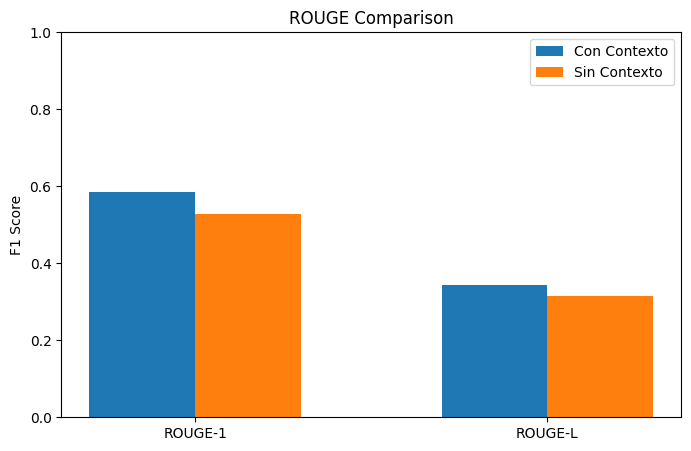

In [21]:
source_text =  """
El científico que propuso un modelo atómico en 1913 fue Niels Bohr.

Su propuesta consistía en que los electrones giran alrededor del núcleo en órbitas definidas y con niveles de energía cuantizados. Esto permitía explicar fenómenos como el espectro de emisión del hidrógeno, que no podía describirse con modelos anteriores.

Explicación adicional:
El modelo de Bohr fue un gran avance porque combinó la física clásica con las ideas de la naciente teoría cuántica. Aunque más tarde fue reemplazado por el modelo mecánico-cuántico (Schrödinger y Heisenberg), sigue siendo fundamental en la enseñanza de la física porque introdujo la idea de niveles de energía discretos para los electrones.
"""
summary_a = respuesta1 # con contexto
summary_b = respuesta2 # sin contexto

scores_a = compute_rouge(source_text, summary_a)
scores_b = compute_rouge(source_text, summary_b)
print('ROUGE Con Contexto:', scores_a)
print('ROUGE Sin Contexto:', scores_b)

bleu_a = compute_bleu(summary_a, [source_text])
bleu_b = compute_bleu(summary_b, [source_text])
print('BLEU Con Contexto:', bleu_a)
print('BLEU Sin Contexto:', bleu_b)


# Simple visualization for F1
labels = ['ROUGE-1', 'ROUGE-L']
a_f1 = [scores_a['rouge1']['f1'], scores_a['rougeL']['f1']]
b_f1 = [scores_b['rouge1']['f1'], scores_b['rougeL']['f1']]
x = range(len(labels))
plt.figure(figsize=(8,5))
plt.bar([i-0.15 for i in x], a_f1, width=0.3, label='Con Contexto')
plt.bar([i+0.15 for i in x], b_f1, width=0.3, label='Sin Contexto')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('F1 Score')
plt.title('ROUGE Comparison')
plt.legend()
plt.show()

### 2. GraphRAG con Gemini + Neo4j

ROUGE Con Contexto: {'rouge1': {'precision': 0.4603174603174603, 'recall': 0.6541353383458647, 'f1': 0.5403726708074534}, 'rougeL': {'precision': 0.3544973544973545, 'recall': 0.5037593984962406, 'f1': 0.4161490683229813}}
ROUGE Sin Contexto: {'rouge1': {'precision': 0.12311901504787962, 'recall': 0.6766917293233082, 'f1': 0.20833333333333331}, 'rougeL': {'precision': 0.07523939808481532, 'recall': 0.41353383458646614, 'f1': 0.12731481481481483}}
BLEU Con Contexto: 0.21952336794881874
BLEU Sin Contexto: 0.017929649499946517


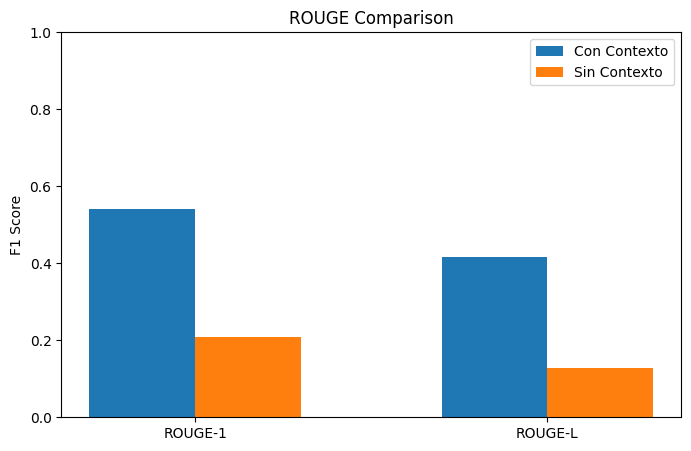

In [22]:
source_text =  """
Elon Musk

Tesla: fabricante de automóviles eléctricos y soluciones de energía renovable.
 Importancia: ha impulsado la transición hacia la movilidad sostenible y la reducción de la dependencia de combustibles fósiles.

SpaceX: empresa de exploración espacial que desarrolla cohetes y satélites.
 Importancia: ha revolucionado la industria aeroespacial con cohetes reutilizables y proyectos para abaratar y ampliar el acceso al espacio.

PayPal (participó en su creación): sistema de pagos en línea.
 Importancia: transformó las transacciones digitales y sentó las bases del comercio electrónico moderno.

Steve Jobs

Apple: empresa reconocida por sus productos tecnológicos innovadores (iPhone, iPad, MacBook).
 Importancia: fue clave en el desarrollo de la industria de dispositivos inteligentes, cambiando la forma en que las personas se comunican, trabajan y consumen información.
"""
summary_a = respuesta3 # con contexto
summary_b = respuesta4 # sin contexto

scores_a = compute_rouge(source_text, summary_a)
scores_b = compute_rouge(source_text, summary_b)
print('ROUGE Con Contexto:', scores_a)
print('ROUGE Sin Contexto:', scores_b)

bleu_a = compute_bleu(summary_a, [source_text])
bleu_b = compute_bleu(summary_b, [source_text])
print('BLEU Con Contexto:', bleu_a)
print('BLEU Sin Contexto:', bleu_b)

# Simple visualization for F1
labels = ['ROUGE-1', 'ROUGE-L']
a_f1 = [scores_a['rouge1']['f1'], scores_a['rougeL']['f1']]
b_f1 = [scores_b['rouge1']['f1'], scores_b['rougeL']['f1']]
x = range(len(labels))
plt.figure(figsize=(8,5))
plt.bar([i-0.15 for i in x], a_f1, width=0.3, label='Con Contexto')
plt.bar([i+0.15 for i in x], b_f1, width=0.3, label='Sin Contexto')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('F1 Score')
plt.title('ROUGE Comparison')
plt.legend()
plt.show()

### 3.FusionRAG

ROUGE Con Contexto: {'rouge1': {'precision': 0.7391304347826086, 'recall': 0.3695652173913043, 'f1': 0.49275362318840565}, 'rougeL': {'precision': 0.42028985507246375, 'recall': 0.21014492753623187, 'f1': 0.28019323671497587}}
ROUGE Sin Contexto B: {'rouge1': {'precision': 0.37037037037037035, 'recall': 0.7246376811594203, 'f1': 0.49019607843137253}, 'rougeL': {'precision': 0.2222222222222222, 'recall': 0.43478260869565216, 'f1': 0.29411764705882354}}
BLEU Con Contexto: 0.07236497830648353
BLEU Sin Contexto: 0.13466431564720913


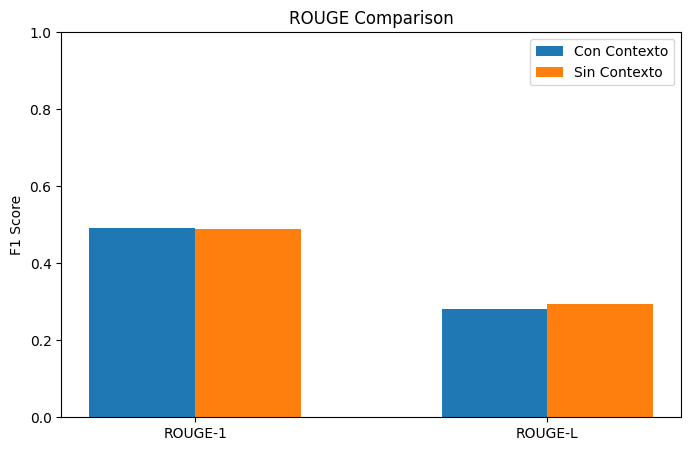

In [24]:
source_text =  """
El científico que propuso un modelo atómico en 1913 fue Niels Bohr.

Bohr planteó que los electrones no se movían libremente alrededor del núcleo, sino que ocupaban órbitas o niveles de energía cuantizados. Solo podían pasar de un nivel a otro emitiendo o absorbiendo energía en forma de cuantos (fotones).

Este modelo fue crucial porque combinó la física clásica con la naciente teoría cuántica, explicando con éxito fenómenos como el espectro de emisión del hidrógeno, algo que los modelos anteriores (como el de Rutherford) no podían justificar. Aunque luego fue reemplazado por modelos más avanzados (como el mecánico-cuántico de Schrödinger y Heisenberg), el modelo de Bohr marcó un hito en la comprensión de la estructura atómica.
"""
summary_a = respuesta5 # con contexto
summary_b = respuesta6 # sin contexto

scores_a = compute_rouge(source_text, summary_a)
scores_b = compute_rouge(source_text, summary_b)
print('ROUGE Con Contexto:', scores_a)
print('ROUGE Sin Contexto B:', scores_b)

bleu_a = compute_bleu(summary_a, [source_text])
bleu_b = compute_bleu(summary_b, [source_text])
print('BLEU Con Contexto:', bleu_a)
print('BLEU Sin Contexto:', bleu_b)

# Simple visualization for F1
labels = ['ROUGE-1', 'ROUGE-L']
a_f1 = [scores_a['rouge1']['f1'], scores_a['rougeL']['f1']]
b_f1 = [scores_b['rouge1']['f1'], scores_b['rougeL']['f1']]
x = range(len(labels))
plt.figure(figsize=(8,5))
plt.bar([i-0.15 for i in x], a_f1, width=0.3, label='Con Contexto')
plt.bar([i+0.15 for i in x], b_f1, width=0.3, label='Sin Contexto')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('F1 Score')
plt.title('ROUGE Comparison')
plt.legend()
plt.show()

Resumen de Métricas

1.Basic RAG

- ROUGE: Con contexto, F1 de ROUGE-1 (0.586 vs 0.528) y ROUGE-L (0.343 vs 0.314) fueron un poco mejores.

- BLEU: Con contexto también fue ligeramente superior (0.161 vs 0.160).

- Conclusión: Exitese una ligera mejora con contexto

2.GraphRAG

- ROUGE: Con contexto, mejoras claras en ROUGE-1 (0.540 vs 0.208) y ROUGE-L (0.416 vs 0.127).

- BLEU: Aumenta de forma notable (0.220 vs 0.018).

- Conclusión: El contexto del grafo aporta un impacto muy positivo.

3.FusionRAG

- ROUGE: Resultados muy similares entre con y sin contexto (0.493 vs 0.490 en ROUGE-1; 0.280 vs 0.294 en ROUGE-L).

- BLEU: Sin contexto fue un poco mejor (0.135 vs 0.072).

- Conclusión: No se aprecia una mejora clara con el contexto.